<a href="https://colab.research.google.com/github/wasanahere/qcomp/blob/main/QAOA_MaxCut_ideas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!python -m pip install pennylane pennylane-lightning pennylane-lightning-gpu --upgrade
!pip install custatevec-cu12

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 37.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 78.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 56.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.0/930.0 kB 58.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 82.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 116.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 16.1 MB/s eta 0:00:00


In [ ]:
# Import statements
import pennylane as qml
from pennylane import qaoa
from pennylane import numpy as np
from matplotlib import pyplot as plt
import networkx as nx
import time

SEED = 420

In [ ]:
def qaoa_maxcut(g, depth, updates=30, show=False, print_update_every=100):
    cost_h, mixer_h = qaoa.maxcut(g)

    def qaoa_layer(gamma, beta):
        qaoa.cost_layer(gamma, cost_h)
        qaoa.mixer_layer(beta, mixer_h)

    wires = range(g.order())

    def circuit(ps):
        for w in wires:
            qml.Hadamard(wires=w)
        qml.layer(qaoa_layer, depth, ps[0], ps[1])

    dev = qml.device("lightning.gpu", wires=wires)

    @qml.qnode(dev)
    def cost_function(ps):
        circuit(ps)
        return qml.expval(cost_h)

    optimizer = qml.AdagradOptimizer(stepsize=0.5)
    init_params = 0.01 * np.random.rand(2, depth, requires_grad=True)
    params = init_params.copy()
    for i in range(updates):
        params = optimizer.step(cost_function, params)
        if show and (i + 1) % print_update_every == 0:
            print(f"Objective after step {i+1:3d}: {-cost_function(params): .7f}")

    if show:
        print("Optimal Parameters")
        print(params)

    @qml.qnode(dev)
    def probability_circuit(gamma, alpha):
        circuit([gamma, alpha])
        return qml.probs(wires=wires)

    probs = probability_circuit(params[0], params[1])
    approx_cost = -cost_function(params)

    return cost_h, params, approx_cost, probs

In [ ]:
class Experiment:
    def __init__(self, dataset=None, generator=None, size=None, max_depth=2, d=None):
        self.size = size
        self.max_depth = max_depth
        if dataset is None:
            if d is None:
              self.regular = False
            else:
              self.regular = True

            if self.regular:
                self.dataset = []
                for n in range(4, size + 1):
                    if n % 2 == 0:
                        self.dataset.append(generator(d, n, seed=SEED))

            else:
                self.dataset = [generator(n) for n in range(4, size + 1)]

        else:
          self.dataset = dataset
        self.params = []
        self.approx_costs = []
        self.probs = []
        self.quantum_time = []
        self.approx_ratios = []

        self.true_costs = []
        self.classical_time = []

    def example(self):
        graph = self.dataset[-1]
        positions = nx.spring_layout(graph, seed=SEED)
        nx.draw(graph, with_labels=True, pos=positions)

    def plot_probs(self, i):
        labels = [bin(n) for n in range(len(self.probs[i]))]
        plt.bar(labels, self.probs[i])
        plt.show()

    def quantum_solve(self):
        for p in range(1, self.max_depth + 1):
            pa, ac, pr, t = [], [], [], []
            for graph in self.dataset:
                start_time = time.perf_counter()
                r1, r2, r3 = qaoa_maxcut(graph, p)
                end_time = time.perf_counter()
                pa.append(r1)
                ac.append(r2)
                pr.append(r3)
                t.append(end_time - start_time)
            self.params.append(pa)
            self.approx_costs.append(ac)
            self.probs.append(pr)
            self.quantum_time.append(t)

    def classical_solve(self):
        for graph in self.dataset:
            start_time = time.perf_counter()
            cost, _ = nx.approximation.one_exchange(graph)
            end_time = time.perf_counter()
            self.classical_time.append(end_time - start_time)
            self.true_costs.append(cost)

    def solve(self):
        self.quantum_solve()
        self.classical_solve()
        helper = np.reshape(np.repeat(self.true_costs, self.max_depth), (self.max_depth, len(self.dataset)))
        self.approx_ratios = np.array(self.approx_costs) / helper


    def results(self):
        for i in range(self.max_depth):
            if self.regular:
                ints = []
                for j in range(4, self.size + 1):
                    if j % 2 == 0:
                      ints.append(j)
                plt.plot(ints, self.approx_costs[i], "o--", label=f"p = {i + 1}")

            else:
              plt.plot(range(4, self.size + 1), self.approx_costs[i], "o--", label=f"p = {i + 1}")


        if self.regular:
            plt.plot(ints, self.true_costs, "o--", label=f"classical cost")
        else:
            plt.plot(range(4, self.size + 1), self.true_costs, "o--", label=f"classical cost")

        plt.legend(loc="upper left")
        plt.title("QAOA for Max Cut")
        plt.xlabel("Size of the graph")
        plt.ylabel("Cost")
        plt.ylim(ymin=0)
        plt.xticks(range(4, self.size + 1))
        plt.show()

    def plot_runtime(self):
        for i in range(self.max_depth):
            if self.regular:
                ints = []
                for j in range(4, self.size + 1):
                    if j % 2 == 0:
                      ints.append(j)
                plt.plot(ints, self.quantum_time[i], "o--", label=f"p = {i + 1}")


            else:
              plt.plot(range(4, self.size + 1), self.quantum_time[i], "o--", label=f"p = {i + 1}")

        if self.regular:
            plt.plot(ints, self.classical_time, "o--", label=f"classical runtime")
        else:
            plt.plot(range(4, self.size + 1), self.classical_time, "o--", label=f"classical runtime")

        plt.legend(loc="upper left")
        plt.title("QAOA for Max Cut")
        plt.xlabel("Size of the graph")
        plt.ylabel("Runtime (s)")
        plt.ylim(ymin=0)
        plt.xticks(range(4, self.size + 1))
        plt.show()

In [ ]:
# Experiments
DEPTH = 3

cycle_graphs = Experiment(nx.cycle_graph, 17, max_depth=DEPTH)
complete_graphs = Experiment(nx.complete_graph, 17, max_depth=DEPTH)
three_regular_graphs = Experiment(nx.random_regular_graph, 17, d=3, max_depth=DEPTH)

ladder_graphs = Experiment(nx.ladder_graph, 10, max_depth=DEPTH)
circular_ladder_graphs = Experiment(nx.circular_ladder_graph, 10, max_depth=DEPTH)

wheel_graphs = Experiment(nx.wheel_graph, 10, max_depth=DEPTH)
star_graphs = Experiment(nx.star_graph, 10, max_depth=DEPTH)

In [ ]:
cycle_graphs.solve()

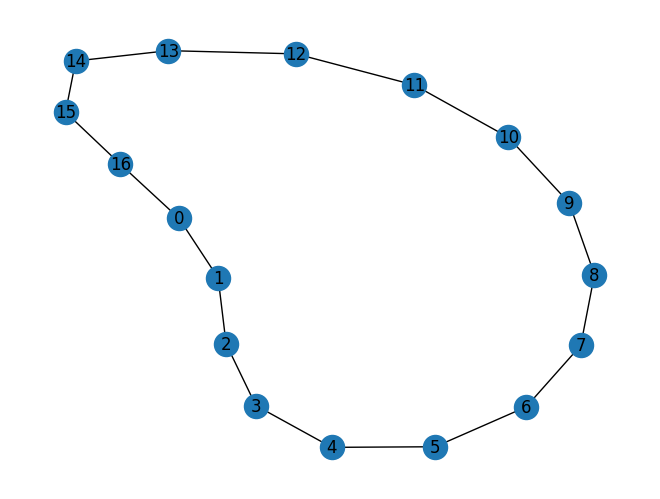

In [ ]:
cycle_graphs.example()

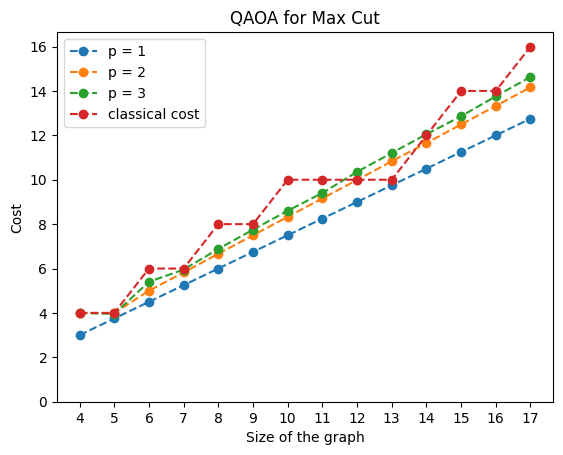

In [ ]:
cycle_graphs.results()

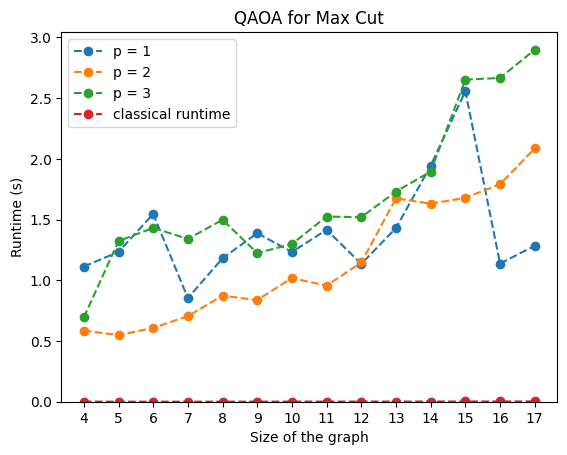

In [ ]:
cycle_graphs.plot_runtime()

In [ ]:
complete_graphs.solve()

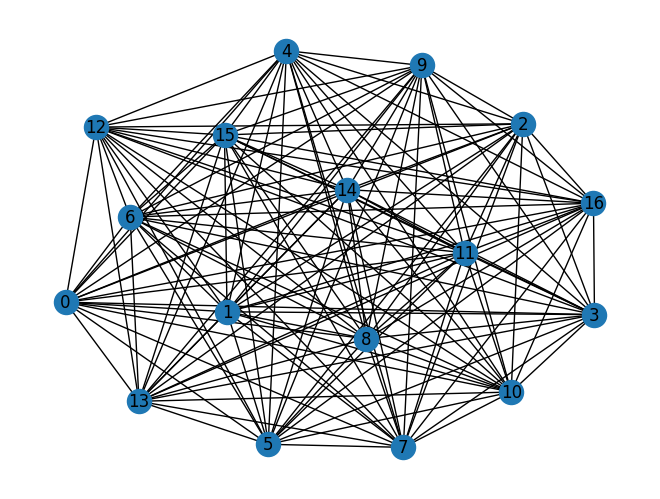

In [ ]:
complete_graphs.example()

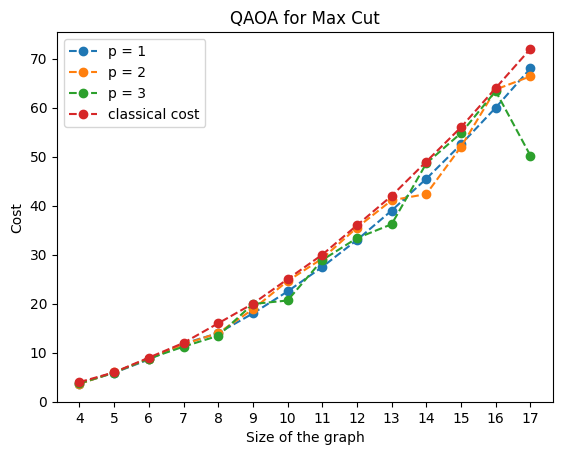

In [ ]:
complete_graphs.results()

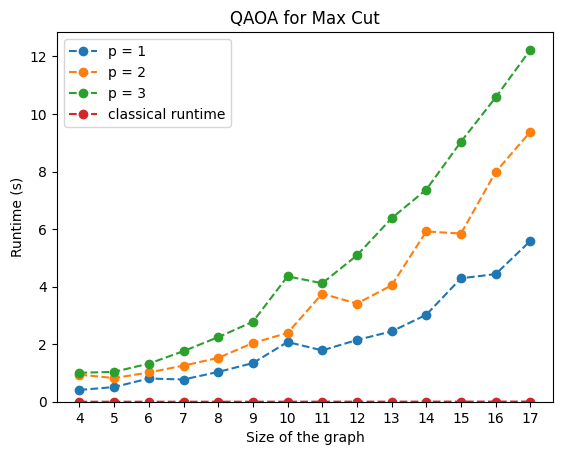

In [ ]:
complete_graphs.plot_runtime()

In [ ]:
three_regular_graphs.solve()

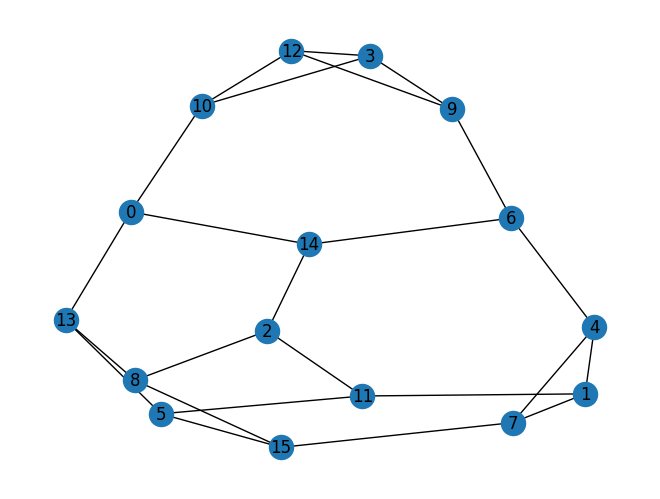

In [ ]:
three_regular_graphs.example()

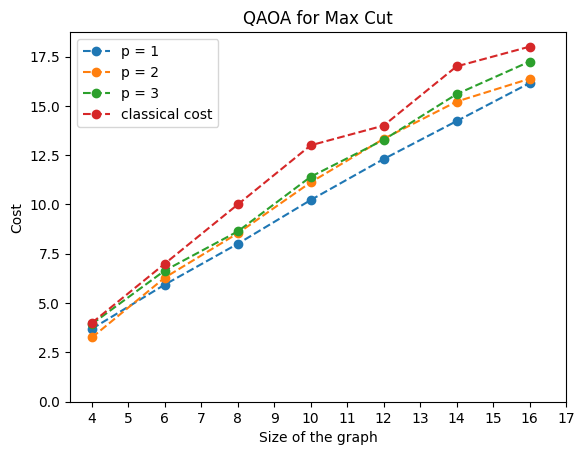

In [ ]:
three_regular_graphs.results()

In [ ]:
approx_ratio = np.array(three_regular_graphs.approx_costs) / np.array(three_regular_graphs.true_costs)
print(approx_ratio)

[[0.92432921 0.84846035 0.80069212 0.78664697 0.87876569 0.83682781
  0.89743843]
 [0.81428251 0.89901001 0.85388301 0.85564693 0.95203771 0.89501855
  0.90959798]
 [0.98541719 0.95024297 0.86339651 0.87738999 0.94830418 0.91725298
  0.95791939]]


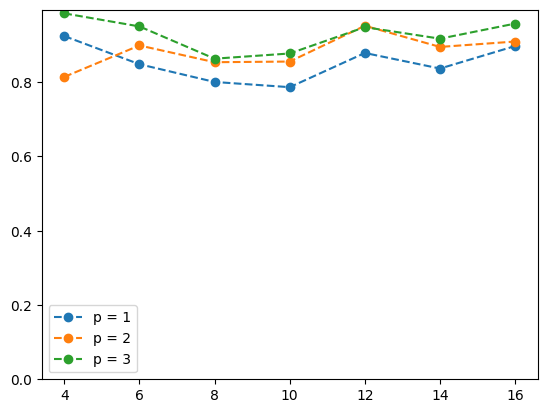

In [ ]:
ints = []
for i in range(4, 17):
  if i % 2 == 0:
    ints.append(i)
for j, thing in enumerate(approx_ratio):
  plt.plot(ints, thing, "o--", label=f"p = {j + 1}")
plt.ylim(ymin=0)
plt.legend()
plt.show()

In [ ]:
# three regular graphs
d = 3
datasets = []
for n in range(4, 17, 2):
  datasets.append([nx.random_regular_graph(d, n) for _ in range(5)])

In [ ]:
costH, _= qaoa.maxcut(nx.random_regular_graph(3, 12))
print(costH)
qml.eigvals(costH)

0.5 * (Z(0) @ Z(7)) + 0.5 * (Z(0) @ Z(4)) + 0.5 * (Z(0) @ Z(10)) + 0.5 * (Z(1) @ Z(2)) + 0.5 * (Z(1) @ Z(11)) + 0.5 * (Z(1) @ Z(4)) + 0.5 * (Z(2) @ Z(10)) + 0.5 * (Z(2) @ Z(6)) + 0.5 * (Z(3) @ Z(8)) + 0.5 * (Z(3) @ Z(5)) + 0.5 * (Z(3) @ Z(11)) + 0.5 * (Z(4) @ Z(9)) + 0.5 * (Z(5) @ Z(8)) + 0.5 * (Z(5) @ Z(6)) + 0.5 * (Z(6) @ Z(9)) + 0.5 * (Z(7) @ Z(8)) + 0.5 * (Z(7) @ Z(11)) + 0.5 * (Z(9) @ Z(10)) + -0.5 * (I(0) @ I(7)) + -0.5 * (I(0) @ I(4)) + -0.5 * (I(0) @ I(10)) + -0.5 * (I(1) @ I(2)) + -0.5 * (I(1) @ I(11)) + -0.5 * (I(1) @ I(4)) + -0.5 * (I(2) @ I(10)) + -0.5 * (I(2) @ I(6)) + -0.5 * (I(3) @ I(8)) + -0.5 * (I(3) @ I(5)) + -0.5 * (I(3) @ I(11)) + -0.5 * (I(4) @ I(9)) + -0.5 * (I(5) @ I(8)) + -0.5 * (I(5) @ I(6)) + -0.5 * (I(6) @ I(9)) + -0.5 * (I(7) @ I(8)) + -0.5 * (I(7) @ I(11)) + -0.5 * (I(9) @ I(10))


array([-16., -16., -15., ...,  -3.,   0.,   0.])

In [ ]:
# 3reg graph
# error bars 10 sample
# symmetry exchange lavbels shouldnt matter
# probs for every layer for size 4
# paper graph
# p on the x axis
# premise exp google

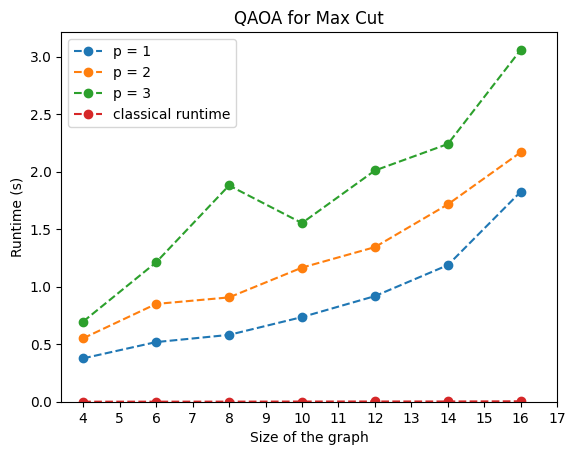

In [ ]:
three_regular_graphs.plot_runtime()

In [ ]:
ladder_graphs.solve()

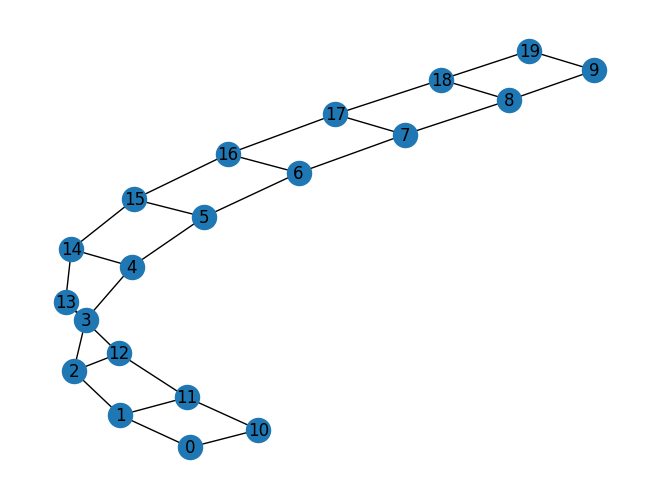

In [ ]:
ladder_graphs.example()

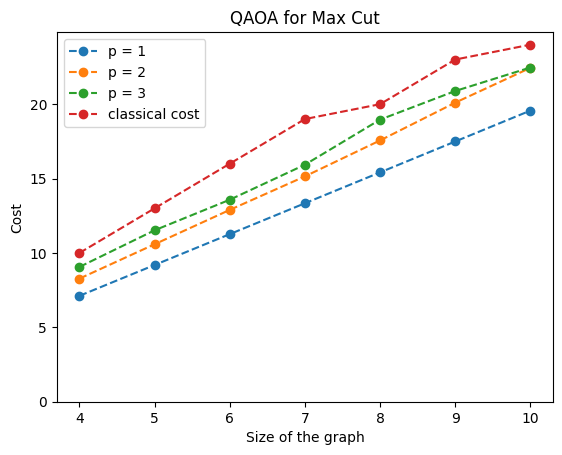

In [ ]:
ladder_graphs.results()

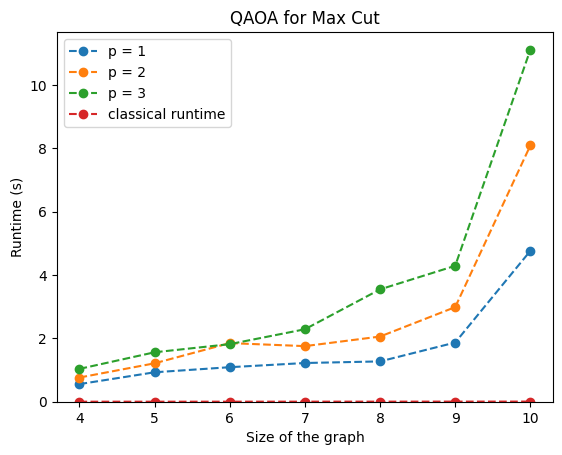

In [ ]:
ladder_graphs.plot_runtime()

In [ ]:
circular_ladder_graphs.solve()

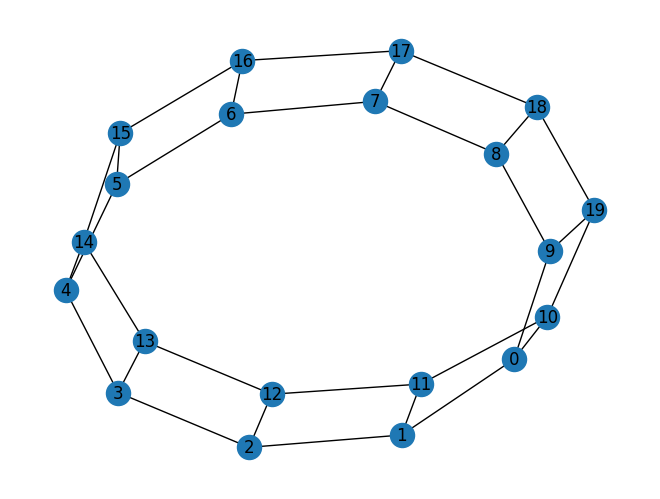

In [ ]:
circular_ladder_graphs.example()

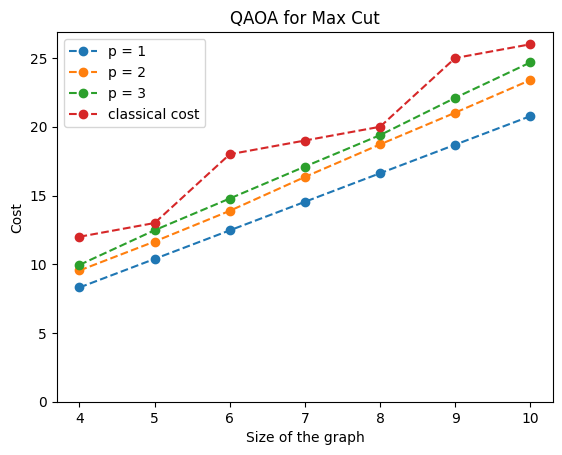

In [ ]:
circular_ladder_graphs.results()

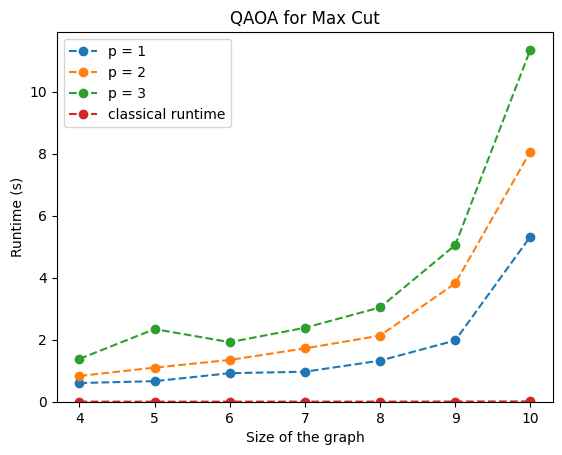

In [ ]:
circular_ladder_graphs.plot_runtime()

In [ ]:
star_graphs.solve()

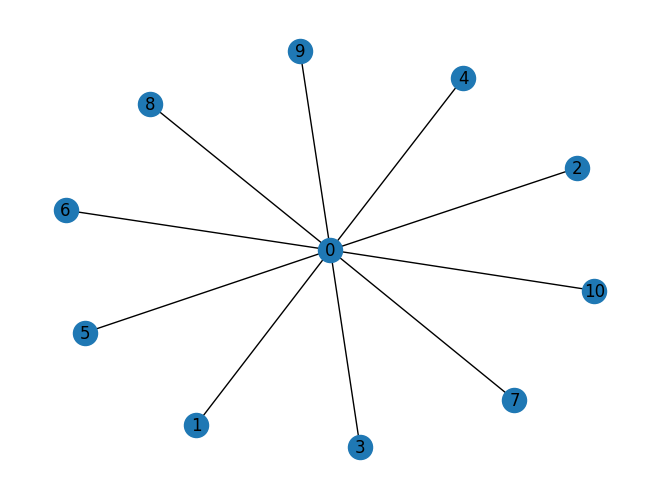

In [ ]:
star_graphs.example()

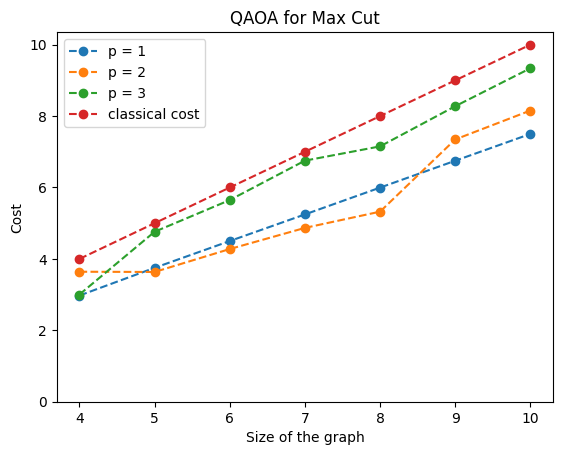

In [ ]:
star_graphs.results()

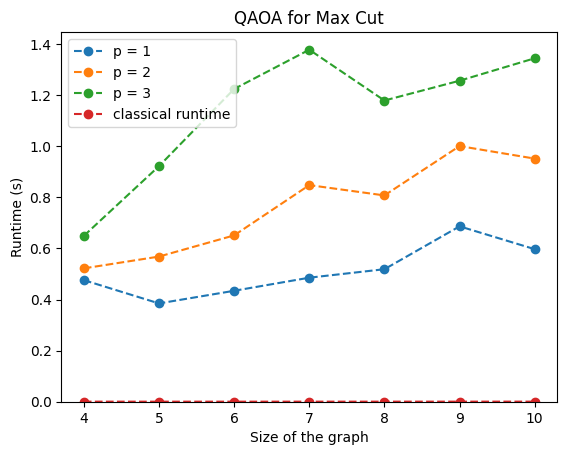

In [ ]:
star_graphs.plot_runtime()

In [ ]:
wheel_graphs.solve()

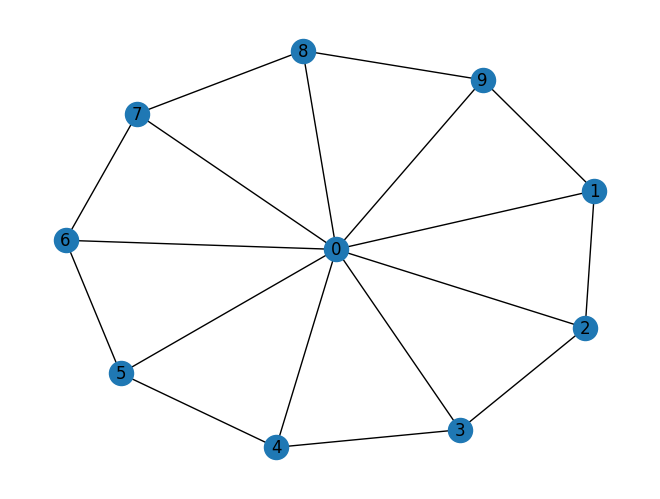

In [ ]:
wheel_graphs.example()

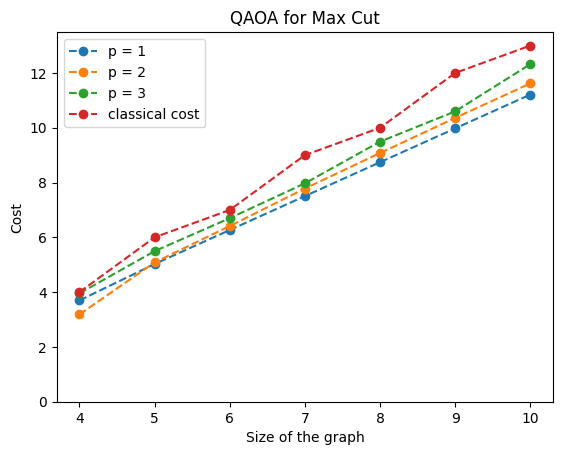

In [ ]:
wheel_graphs.results()

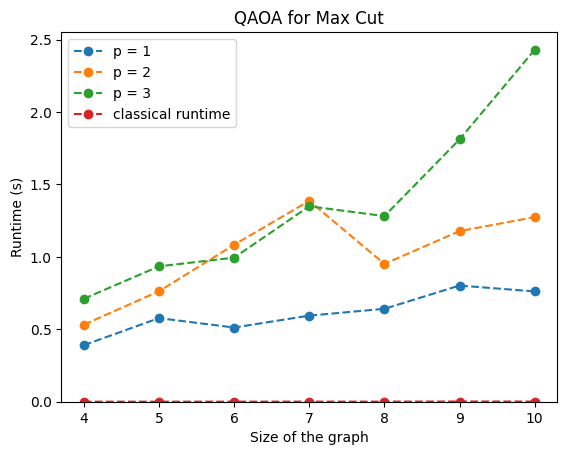

In [ ]:
wheel_graphs.plot_runtime()

In [ ]:
three_regular_graphs.example()

NameError: name 'three_regular_graphs' is not defined